# Model Stability Analysis: 50% vs 100% Data Training Comparison

This notebook analyzes the stability of the LightGBM model from "Step2 black box GS 1.ipynb" by:
1. Training a model on 50% of the data
2. Training the same model on 100% of the data
3. Extracting and comparing feature importance between both models
4. Computing distance metrics to quantify how feature importance changes with more data

## Objectives:
- Assess how feature importance stability changes with dataset size
- Identify features whose importance is sensitive to training data size
- Quantify feature importance consistency between 50% vs 100% training data
- Understand model robustness to data availability


In [1]:
# Import required libraries
import pandas as pd 
import os, sys, re, json, math, warnings
warnings.filterwarnings("ignore")
import numpy as np
import polars as pl
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine, euclidean, cityblock
from scipy.stats import spearmanr, pearsonr
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import pyarrow as pa

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
pl.enable_string_cache()

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Copy all utility functions from the original notebook

# Constants from original notebook
FORBID_COLS = {
    "unnamed_0", "predictions", "predicted_probabilities", "pct_afro_american", "zip_code"
}
TARGET_COL = "target"
TIME_COL = "issue_d"

CANDIDATE_COLS = [
    "issue_d","loan_duration","annual_inc","avg_cur_bal","bc_open_to_buy","bc_util",
    "delinq_2yrs","dti","emp_length","purpose","revol_bal","revol_util","sub_grade",
    "target","tax_liens","pct_afro_american","predictions","predicted_probabilities",
    "zip_code","unnamed_0"
]

CAST_MAP = {
    "issue_d": pl.Int32,
    "loan_duration": pl.Int8,
    "annual_inc": pl.Float32,
    "avg_cur_bal": pl.Float32,
    "bc_open_to_buy": pl.Float32,
    "bc_util": pl.Float32,
    "delinq_2yrs": pl.Int8,
    "dti": pl.Float32,
    "emp_length": pl.Utf8,
    "purpose": pl.Utf8,
    "revol_bal": pl.Float32,
    "revol_util": pl.Float32,
    "sub_grade": pl.Utf8,
    "target": pl.Int8,
    "tax_liens": pl.Int8,
    "zip_code": pl.Utf8,
    "pct_afro_american": pl.Float32,
    "predictions": pl.Int8,
    "predicted_probabilities": pl.Float32,
    "unnamed_0": pl.Int64
}

def to_snake(s: str) -> str:
    s = s.strip().replace("%","pct")
    s = re.sub(r"[^\w]+", "_", s)
    s = re.sub(r"_+", "_", s)
    return s.strip("_").lower()

def scan_any(path: str) -> pl.LazyFrame:
    ext = os.path.splitext(path)[1].lower()
    if ext in [".csv", ".txt"]:
        return pl.scan_csv(path, ignore_errors=True, try_parse_dates=False, null_values=["", "NA", "NaN", "null"])
    elif ext in [".parquet", ".pq"]:
        return pl.scan_parquet(path)
    else:
        raise ValueError(f"Unsupported file: {path}")

def parse_emp_length(s: str) -> float:
    if s is None: return np.nan
    s = str(s).lower().strip()
    if s in ("n/a", "na", "nan", ""): return np.nan
    if "10+" in s: return 10.0
    m = re.search(r"(\d+)\s*years?", s)
    if m: return float(m.group(1))
    if "year" in s and re.search(r"\d", s) is None: return 1.0
    return np.nan

def subgrade_to_ordinal(s: str) -> int:
    if s is None: return -1
    s = str(s).strip().upper()
    if len(s) < 2: return -1
    letter = s[0]; num = s[1:]
    base = {"A":0,"B":5,"C":10,"D":15,"E":20,"F":25,"G":30}.get(letter, -5)
    try:
        return base + (int(num) - 1)
    except:
        return -1

def best_threshold_by_f1(y_true, y_prob):
    ps, rs, ths = precision_recall_curve(y_true, y_prob)[:3]
    fs = []
    for p, r in zip(ps[:-1], rs[:-1]):
        if p + r == 0:
            fs.append(0.0)
        else:
            fs.append(2 * p * r / (p + r))
    if not fs:
        return 0.5, 0.0
    idx = int(np.argmax(fs))
    return float(ths[idx]), float(fs[idx])

print("Utility functions loaded successfully!")


Utility functions loaded successfully!


In [3]:
# Feature engineering function from original notebook
def fe(df: pl.DataFrame) -> pl.DataFrame:
    d = df

    # 1) Parse emp_length → years
    if "emp_length" in d.columns:
        d = d.with_columns(
            pl.col("emp_length").map_elements(parse_emp_length, return_dtype=pl.Float32).alias("emp_len_years")
        )

    # 2) sub_grade A1..G5 → ordinal
    if "sub_grade" in d.columns:
        d = d.with_columns(
            pl.col("sub_grade").map_elements(subgrade_to_ordinal, return_dtype=pl.Int8).alias("sub_grade_ord")
        )

    # 3) Percentage fields → 0–1
    for col in ["revol_util", "bc_util"]:
        if col in d.columns:
            d = d.with_columns((pl.col(col) / 100.0).alias(col))

    # 4) Common constructed features
    if {"revol_bal", "annual_inc"} <= set(d.columns):
        d = d.with_columns(
            pl.when(pl.col("annual_inc") > 0)
              .then(pl.col("revol_bal") / pl.col("annual_inc"))
              .otherwise(None)
              .cast(pl.Float32)
              .alias("revol_to_inc")
        )

    if {"avg_cur_bal", "bc_open_to_buy"} <= set(d.columns):
        d = d.with_columns(
            pl.when(pl.col("bc_open_to_buy") + 1e-6 > 0)
              .then(pl.col("avg_cur_bal") / (pl.col("bc_open_to_buy") + 1e-6))
              .otherwise(None)
              .cast(pl.Float32)
              .alias("cur_to_openbuy")
        )

    if "annual_inc" in d.columns:
        d = d.with_columns(
            pl.when(pl.col("annual_inc") < 1)
              .then(1)
              .otherwise(pl.col("annual_inc"))
              .log()
              .alias("log_annual_inc")
        )

    if "dti" in d.columns:
        d = d.with_columns(
            pl.when(pl.col("dti") < 0)
              .then(0)
              .when(pl.col("dti") > 100)
              .then(100)
              .otherwise(pl.col("dti"))
              .alias("dti_clip")
        )

    # 5) Handle categorical missing values
    for c in ["purpose"]:
        if c in d.columns:
            d = d.with_columns(pl.col(c).fill_null("Unknown"))

    # 6) Drop forbidden columns
    keep = [c for c in d.columns if c not in FORBID_COLS]
    d = d.select(keep)

    return d

print("Feature engineering function loaded!")


Feature engineering function loaded!


In [4]:
# Load and preprocess the data (matching original notebook approach)
data_path = "Step2 my blackbox model solal/dataproject2025.csv"

print("Loading data...")
lf = scan_any(data_path)

# Rename columns to snake_case
cols_current = lf.columns
rename_map = {c: to_snake(c) for c in cols_current}
lf = lf.rename(rename_map)

# Select relevant columns
selected = [c for c in CANDIDATE_COLS if c in lf.columns]
if not selected:
    selected = lf.columns
lf = lf.select(selected)

# Cast columns to appropriate types
casts = []
for k, v in CAST_MAP.items():
    if k in lf.columns:
        casts.append(pl.col(k).cast(v, strict=False))
if casts:
    lf = lf.with_columns(casts)

print(f"Data loaded with columns: {lf.columns}")
print(f"Data shape (before collection): {lf.collect().shape}")

# Split by time (following original approach)
if TIME_COL not in lf.columns:
    raise RuntimeError(f"Missing time column `{TIME_COL}` after normalization.")

train_lazy = lf.filter(pl.col(TIME_COL) <= 2015)
test_lazy = lf.filter(pl.col(TIME_COL) > 2015)

# Apply feature engineering
train_df = fe(train_lazy.collect())
test_df = fe(test_lazy.collect())

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

if TARGET_COL not in train_df.columns or TARGET_COL not in test_df.columns:
    raise RuntimeError(f"Missing target column `{TARGET_COL}` in data.")

# We'll use the training data for our stability analysis
# Convert to pandas for easier manipulation
train_pd = train_df.to_pandas()
print(f"Training data converted to pandas: {train_pd.shape}")
print(f"Target distribution: {train_pd[TARGET_COL].value_counts()}")


Loading data...
Data loaded with columns: ['issue_d', 'loan_duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'target', 'tax_liens', 'pct_afro_american', 'predictions', 'predicted_probabilities', 'zip_code']
Data shape (before collection): (1086683, 19)
Training data shape: (524431, 21)
Test data shape: (561805, 21)
Training data converted to pandas: (524431, 21)
Target distribution: target
0    419622
1    104809
Name: count, dtype: int64


In [5]:
# Data preparation for 50% vs 100% training comparison
print("=== DATA PREPARATION FOR 50% vs 100% COMPARISON ===")

# Prepare the full training dataset
X_full = train_pd.drop(columns=[TARGET_COL])
y_full = train_pd[TARGET_COL]

print(f"Full dataset size: {X_full.shape[0]} samples")
print(f"Full target distribution: {y_full.value_counts().to_dict()}")

# Create a 50% subset with stratification to maintain class balance
X_subset, X_remaining, y_subset, y_remaining = train_test_split(
    X_full, y_full, 
    test_size=0.5, 
    random_state=SEED, 
    stratify=y_full
)

print(f"\n50% subset size: {X_subset.shape[0]} samples")
print(f"50% subset target distribution: {y_subset.value_counts().to_dict()}")

print(f"\nRemaining 50% size: {X_remaining.shape[0]} samples") 
print(f"Remaining 50% target distribution: {y_remaining.value_counts().to_dict()}")

# Verify the class balance is maintained
print(f"\nClass balance verification:")
print(f"50% subset positive rate: {y_subset.mean():.4f}")
print(f"Full dataset positive rate: {y_full.mean():.4f}")
print(f"Difference: {abs(y_subset.mean() - y_full.mean()):.4f}")

# Save the split information for reproducibility
split_info = {
    "total_samples": len(X_full),
    "subset_50_samples": len(X_subset),
    "subset_50_positive_rate": float(y_subset.mean()),
    "full_dataset_positive_rate": float(y_full.mean()),
    "random_seed": SEED,
    "comparison_type": "50% vs 100% training data"
}

print(f"\nSplit information: {split_info}")
print("\nWe will train:")
print("- Model 1: On 50% of the data")
print("- Model 2: On 100% of the data")
print("- Then compare their feature importance")


=== DATA PREPARATION FOR 50% vs 100% COMPARISON ===
Full dataset size: 524431 samples
Full target distribution: {0: 419622, 1: 104809}

50% subset size: 262215 samples
50% subset target distribution: {0: 209811, 1: 52404}

Remaining 50% size: 262216 samples
Remaining 50% target distribution: {0: 209811, 1: 52405}

Class balance verification:
50% subset positive rate: 0.1999
Full dataset positive rate: 0.1999
Difference: 0.0000

Split information: {'total_samples': 524431, 'subset_50_samples': 262215, 'subset_50_positive_rate': 0.1998512670899834, 'full_dataset_positive_rate': 0.19985279283642654, 'random_seed': 42, 'comparison_type': '50% vs 100% training data'}

We will train:
- Model 1: On 50% of the data
- Model 2: On 100% of the data
- Then compare their feature importance


In [6]:
# Data preprocessing for LightGBM training
def preprocess_for_lgb(X_train, y_train):
    """Preprocess data for LightGBM training following original notebook approach"""
    
    # Handle missing values
    X_processed = X_train.copy()
    
    # Numerical columns: fill with median
    for col in X_processed.columns:
        if pd.api.types.is_numeric_dtype(X_processed[col]):
            X_processed[col] = X_processed[col].astype("float32")
            if X_processed[col].isna().any():
                X_processed[col] = X_processed[col].fillna(X_processed[col].median())
        else:
            # Categorical columns: fill with "Unknown"
            X_processed[col] = X_processed[col].astype("object").fillna("Unknown")
    
    # Identify categorical columns
    cat_cols = [c for c in X_processed.columns if X_processed[c].dtype.name in ("object", "category")]
    
    # Convert categorical columns to category type
    for c in cat_cols:
        X_processed[c] = X_processed[c].astype("category")
    
    return X_processed, cat_cols

# Preprocess both datasets (50% subset and full dataset)
print("Preprocessing data for LightGBM training...")

X_subset_processed, cat_cols_subset = preprocess_for_lgb(X_subset, y_subset)
X_full_processed, cat_cols_full = preprocess_for_lgb(X_full, y_full)

print(f"Categorical columns detected: {cat_cols_subset}")
print(f"Numerical features: {len(X_subset_processed.columns) - len(cat_cols_subset)}")
print(f"Categorical features: {len(cat_cols_subset)}")

# Ensure both datasets have same categorical encoding
# Use the full dataset's categories as the reference
for col in cat_cols_subset:
    if col in cat_cols_full:
        # Get all unique categories from full dataset
        full_cats = X_full_processed[col].cat.categories
        
        # Apply same categories to subset (this ensures consistency)
        X_subset_processed[col] = X_subset_processed[col].cat.set_categories(full_cats)

print("Data preprocessing completed successfully!")
print("\nDataset sizes after preprocessing:")
print(f"50% subset: {X_subset_processed.shape}")
print(f"Full dataset: {X_full_processed.shape}")


Preprocessing data for LightGBM training...
Categorical columns detected: ['emp_length', 'purpose', 'sub_grade']
Numerical features: 17
Categorical features: 3
Data preprocessing completed successfully!

Dataset sizes after preprocessing:
50% subset: (262215, 20)
Full dataset: (524431, 20)


In [7]:
# LightGBM model training function adapted from original notebook
def train_lightgbm_for_stability(X_train, y_train, cat_cols, model_name="model"):
    """Train LightGBM model following the original notebook approach"""
    
    # Calculate class weights for imbalance handling
    pos = int(y_train.sum())
    neg = int((y_train == 0).sum())
    scale_pos_weight = max(1.0, neg / max(1, pos))
    
    # LightGBM parameters matching original notebook
    params = {
        "objective": "binary",
        "metric": ["auc"],
        "learning_rate": 0.05,
        "num_leaves": 64,
        "max_depth": -1,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "lambda_l1": 0.0,
        "lambda_l2": 0.0,
        "verbose": -1,
        "seed": SEED,
        "scale_pos_weight": scale_pos_weight
    }
    
    print(f"Training {model_name} with {len(X_train)} samples...")
    print(f"Positive class weight: {scale_pos_weight:.3f}")
    
    # Create LightGBM dataset
    lgb_train = lgb.Dataset(
        X_train, 
        label=y_train, 
        categorical_feature=cat_cols, 
        free_raw_data=False  # Keep data for feature importance
    )
    
    # Train model
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=500,
        valid_sets=[lgb_train],
        valid_names=["train"],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
    )
    
    print(f"{model_name} training completed!")
    print(f"Best iteration: {model.best_iteration}")
    
    return model

# Train models on 50% vs 100% data
print("=== TRAINING MODELS ON 50% vs 100% DATA ===")

# Train model on 50% subset
print("\n1. Training model on 50% of data:")
model_50pct = train_lightgbm_for_stability(
    X_subset_processed, y_subset, cat_cols_subset, "Model_50_Percent"
)

# Train model on 100% full dataset
print("\n2. Training model on 100% of data:")
model_100pct = train_lightgbm_for_stability(
    X_full_processed, y_full, cat_cols_full, "Model_100_Percent"
)

print("\n=== MODEL TRAINING COMPLETED ===")
print(f"50% Model best iteration: {model_50pct.best_iteration}")
print(f"100% Model best iteration: {model_100pct.best_iteration}")
print(f"\nTraining data sizes:")
print(f"50% model trained on: {len(X_subset_processed):,} samples")
print(f"100% model trained on: {len(X_full_processed):,} samples")
print(f"Difference: {len(X_full_processed) - len(X_subset_processed):,} additional samples")


=== TRAINING MODELS ON 50% vs 100% DATA ===

1. Training model on 50% of data:
Training Model_50_Percent with 262215 samples...
Positive class weight: 4.004
[50]	train's auc: 0.715944
[100]	train's auc: 0.726339
[150]	train's auc: 0.735657
[200]	train's auc: 0.744251
[250]	train's auc: 0.752508
[300]	train's auc: 0.760656
[350]	train's auc: 0.768384
[400]	train's auc: 0.775873
[450]	train's auc: 0.783045
[500]	train's auc: 0.790063
Model_50_Percent training completed!
Best iteration: 0

2. Training model on 100% of data:
Training Model_100_Percent with 524431 samples...
Positive class weight: 4.004
[50]	train's auc: 0.709602
[100]	train's auc: 0.715802
[150]	train's auc: 0.721064
[200]	train's auc: 0.725835
[250]	train's auc: 0.730338
[300]	train's auc: 0.734953
[350]	train's auc: 0.739304
[400]	train's auc: 0.743622
[450]	train's auc: 0.747753
[500]	train's auc: 0.751851
Model_100_Percent training completed!
Best iteration: 0

=== MODEL TRAINING COMPLETED ===
50% Model best iteration:

## Distance Metric Implementation

This analysis implements the **standard feature importance distance metric**:

### Formula:
$$d(f_1, f_2) = ||\phi(f_1) - \phi(f_2)||_2$$

Where:
- $f_1$ = Model trained on 50% of data  
- $f_2$ = Model trained on 100% of data
- $\phi(f_1)$ = Feature importance vector from model $f_1$
- $\phi(f_2)$ = Feature importance vector from model $f_2$  
- $||\cdot||_2$ = L2 norm (Euclidean distance)

### Implementation:
The distance is computed as the **Euclidean distance** between the normalized feature importance vectors from both models. This measures how much the feature importance rankings change when more training data is available.

**Lower values** indicate higher stability (feature importance remains consistent even with limited data).  
**Higher values** indicate lower stability (feature importance changes significantly with more data).


In [8]:
# Extract feature importance from both models
print("=== EXTRACTING FEATURE IMPORTANCE ===")

# Get feature importance for both models
importance_50pct = model_50pct.feature_importance(importance_type='gain')
importance_100pct = model_100pct.feature_importance(importance_type='gain')

# Get feature names (should be the same for both models)
feature_names_50 = model_50pct.feature_name()
feature_names_100 = model_100pct.feature_name()

# Verify feature consistency
if feature_names_50 != feature_names_100:
    print("Warning: Feature names differ between models!")
    print(f"50% model features: {len(feature_names_50)}")
    print(f"100% model features: {len(feature_names_100)}")

# Use the full model's feature names as reference
feature_names = feature_names_100

# Create feature importance dataframes
importance_df_50 = pd.DataFrame({
    'feature': feature_names_50,
    'importance_50pct': importance_50pct
}).sort_values('importance_50pct', ascending=False)

importance_df_100 = pd.DataFrame({
    'feature': feature_names_100,
    'importance_100pct': importance_100pct
}).sort_values('importance_100pct', ascending=False)

# Merge the importance dataframes
importance_comparison = importance_df_50.merge(
    importance_df_100[['feature', 'importance_100pct']], 
    on='feature', 
    how='outer'
).fillna(0)

# Calculate relative importance (normalized to sum to 1)
importance_comparison['relative_importance_50pct'] = (
    importance_comparison['importance_50pct'] / importance_comparison['importance_50pct'].sum()
)
importance_comparison['relative_importance_100pct'] = (
    importance_comparison['importance_100pct'] / importance_comparison['importance_100pct'].sum()
)

# Calculate importance difference (100% - 50%)
importance_comparison['importance_diff'] = (
    importance_comparison['relative_importance_100pct'] - importance_comparison['relative_importance_50pct']
)

importance_comparison['abs_importance_diff'] = abs(importance_comparison['importance_diff'])

# Sort by 100% model importance (our reference)
importance_comparison['avg_importance'] = (
    importance_comparison['relative_importance_50pct'] + importance_comparison['relative_importance_100pct']
) / 2

importance_comparison = importance_comparison.sort_values('relative_importance_100pct', ascending=False)

print(f"Number of features: {len(importance_comparison)}")
print(f"Feature importance extracted successfully!")

# Display top 15 most important features
print("\n=== TOP 15 FEATURES BY 100% MODEL IMPORTANCE ===")
top_features = importance_comparison.head(15)
for idx, row in top_features.iterrows():
    print(f"{row['feature']:20s} | 50%: {row['relative_importance_50pct']:.4f} | "
          f"100%: {row['relative_importance_100pct']:.4f} | "
          f"Diff: {row['importance_diff']:+.4f}")

print(f"\n=== FEATURES WITH LARGEST IMPORTANCE DIFFERENCES ===")
most_different = importance_comparison.nlargest(10, 'abs_importance_diff')
for idx, row in most_different.iterrows():
    print(f"{row['feature']:20s} | 50%: {row['relative_importance_50pct']:.4f} | "
          f"100%: {row['relative_importance_100pct']:.4f} | "
          f"Diff: {row['importance_diff']:+.4f}")

print(f"\nPositive differences mean feature became MORE important with more data")
print(f"Negative differences mean feature became LESS important with more data")


=== EXTRACTING FEATURE IMPORTANCE ===
Number of features: 20
Feature importance extracted successfully!

=== TOP 15 FEATURES BY 100% MODEL IMPORTANCE ===
sub_grade_ord        | 50%: 0.2942 | 100%: 0.3820 | Diff: +0.0878
sub_grade            | 50%: 0.1183 | 100%: 0.1340 | Diff: +0.0157
avg_cur_bal          | 50%: 0.0760 | 100%: 0.0695 | Diff: -0.0065
dti                  | 50%: 0.0666 | 100%: 0.0564 | Diff: -0.0101
annual_inc           | 50%: 0.0505 | 100%: 0.0397 | Diff: -0.0107
loan_duration        | 50%: 0.0307 | 100%: 0.0362 | Diff: +0.0055
revol_bal            | 50%: 0.0470 | 100%: 0.0341 | Diff: -0.0128
revol_to_inc         | 50%: 0.0425 | 100%: 0.0328 | Diff: -0.0098
bc_open_to_buy       | 50%: 0.0438 | 100%: 0.0320 | Diff: -0.0118
bc_util              | 50%: 0.0419 | 100%: 0.0307 | Diff: -0.0112
revol_util           | 50%: 0.0416 | 100%: 0.0292 | Diff: -0.0124
cur_to_openbuy       | 50%: 0.0407 | 100%: 0.0281 | Diff: -0.0126
issue_d              | 50%: 0.0200 | 100%: 0.0237 | Di

In [9]:
# Distance metrics for feature importance stability analysis
print("=== COMPUTING DISTANCE METRICS FOR STABILITY ANALYSIS ===")

# Get the importance vectors
imp_50pct = importance_comparison['relative_importance_50pct'].values  # φ(f1) - 50% model
imp_100pct = importance_comparison['relative_importance_100pct'].values  # φ(f2) - 100% model

print(f"Feature importance vectors extracted:")
print(f"φ(f1) - 50% model: {len(imp_50pct)} features")
print(f"φ(f2) - 100% model: {len(imp_100pct)} features")

# Compute various distance metrics
distance_metrics = {}

# PRIMARY METRIC: Feature Importance Distance as per formula
# d(f1, f2) = ||φ(f1) - φ(f2)||₂ (L2 norm / Euclidean distance)
feature_importance_distance = euclidean(imp_50pct, imp_100pct)
distance_metrics['feature_importance_distance_L2'] = feature_importance_distance

# Direct implementation of the formula for clarity
feature_importance_distance_manual = np.sqrt(np.sum((imp_50pct - imp_100pct)**2))
distance_metrics['feature_importance_distance_manual'] = feature_importance_distance_manual

print(f"\n=== PRIMARY DISTANCE METRIC ===")
print(f"d(f1, f2) = ||φ(f1) - φ(f2)||₂ = {feature_importance_distance:.6f}")
print(f"Manual calculation verification: {feature_importance_distance_manual:.6f}")
print(f"Match: {np.isclose(feature_importance_distance, feature_importance_distance_manual)}")

# Additional distance metrics for comprehensive analysis

# 1. Cosine Distance (measures angle between vectors)
cosine_dist = cosine(imp_50pct, imp_100pct)
distance_metrics['cosine_distance'] = cosine_dist
distance_metrics['cosine_similarity'] = 1 - cosine_dist

# 2. Euclidean Distance (same as primary metric, kept for completeness)
euclidean_dist = euclidean(imp_50pct, imp_100pct)
distance_metrics['euclidean_distance'] = euclidean_dist

# 3. Manhattan Distance (L1 norm)
manhattan_dist = cityblock(imp_50pct, imp_100pct)
distance_metrics['manhattan_distance'] = manhattan_dist

# 4. Correlation measures
pearson_corr, pearson_p = pearsonr(imp_50pct, imp_100pct)
spearman_corr, spearman_p = spearmanr(imp_50pct, imp_100pct)
distance_metrics['pearson_correlation'] = pearson_corr
distance_metrics['pearson_p_value'] = pearson_p
distance_metrics['spearman_correlation'] = spearman_corr
distance_metrics['spearman_p_value'] = spearman_p

# 5. Total Variation Distance (half of L1 norm for probability distributions)
tv_distance = 0.5 * manhattan_dist
distance_metrics['total_variation_distance'] = tv_distance

# 6. Jensen-Shannon Divergence (symmetric version of KL divergence)
from scipy.spatial.distance import jensenshannon
js_distance = jensenshannon(imp_50pct, imp_100pct)
distance_metrics['jensen_shannon_distance'] = js_distance

# 7. Max absolute difference
max_abs_diff = np.max(np.abs(imp_50pct - imp_100pct))
distance_metrics['max_absolute_difference'] = max_abs_diff

# 8. Mean absolute difference
mean_abs_diff = np.mean(np.abs(imp_50pct - imp_100pct))
distance_metrics['mean_absolute_difference'] = mean_abs_diff

# 9. Root Mean Square Difference
rmse = np.sqrt(np.mean((imp_50pct - imp_100pct)**2))
distance_metrics['rmse'] = rmse

print("\n" + "="*80)
print("=== FEATURE IMPORTANCE DISTANCE ANALYSIS: 50% vs 100% DATA ===")
print("="*80)

print(f"\n🎯 PRIMARY DISTANCE METRIC:")
print(f"   d(f1, f2) = ||φ(f1) - φ(f2)||₂ = {distance_metrics['feature_importance_distance_L2']:.6f}")
print(f"   This measures the L2 norm between feature importance vectors")

print(f"\n📊 ADDITIONAL DISTANCE METRICS (smaller values indicate more similarity):")
print(f"   Cosine Distance:           {distance_metrics['cosine_distance']:.6f}")
print(f"   Manhattan Distance:        {distance_metrics['manhattan_distance']:.6f}")
print(f"   Total Variation Distance:  {distance_metrics['total_variation_distance']:.6f}")
print(f"   Jensen-Shannon Distance:   {distance_metrics['jensen_shannon_distance']:.6f}")
print(f"   RMSE:                      {distance_metrics['rmse']:.6f}")
print(f"   Mean Absolute Difference:  {distance_metrics['mean_absolute_difference']:.6f}")
print(f"   Max Absolute Difference:   {distance_metrics['max_absolute_difference']:.6f}")

print("\nSimilarity Metrics (larger values indicate more consistency):")
print(f"Cosine Similarity:         {distance_metrics['cosine_similarity']:.6f}")
print(f"Pearson Correlation:       {distance_metrics['pearson_correlation']:.6f} (p={distance_metrics['pearson_p_value']:.6f})")
print(f"Spearman Correlation:      {distance_metrics['spearman_correlation']:.6f} (p={distance_metrics['spearman_p_value']:.6f})")

# Overall stability assessment
stability_score = distance_metrics['cosine_similarity']  # Use cosine similarity as primary metric
print(f"\n=== OVERALL CONSISTENCY ASSESSMENT ===")
print(f"Primary Consistency Score (Cosine Similarity): {stability_score:.4f}")

if stability_score > 0.95:
    consistency_level = "Very High - Feature importance very consistent between 50% and 100% data"
elif stability_score > 0.90:
    consistency_level = "High - Feature importance quite consistent between 50% and 100% data"
elif stability_score > 0.80:
    consistency_level = "Moderate - Some differences in feature importance with more data"
elif stability_score > 0.70:
    consistency_level = "Low - Notable differences in feature importance with more data"
else:
    consistency_level = "Very Low - Significant changes in feature importance with more data"

print(f"Consistency Level: {consistency_level}")

print(f"\n=== INTERPRETATION ===")
print(f"This analysis compares feature importance between:")
print(f"- Model trained on 50% of data ({len(X_subset_processed):,} samples)")
print(f"- Model trained on 100% of data ({len(X_full_processed):,} samples)")
print(f"\nHigh similarity scores suggest the model's feature ranking is stable")
print(f"even with limited training data. Low scores suggest more data significantly")
print(f"changes which features the model considers most important.")

# Save results
stability_results = {
    'distance_metrics': distance_metrics,
    'consistency_score': stability_score,
    'consistency_level': consistency_level,
    'split_info': split_info
}

print(f"\nStability analysis completed!")


=== COMPUTING DISTANCE METRICS FOR STABILITY ANALYSIS ===
Feature importance vectors extracted:
φ(f1) - 50% model: 20 features
φ(f2) - 100% model: 20 features

=== PRIMARY DISTANCE METRIC ===
d(f1, f2) = ||φ(f1) - φ(f2)||₂ = 0.095685
Manual calculation verification: 0.095685
Match: True

=== FEATURE IMPORTANCE DISTANCE ANALYSIS: 50% vs 100% DATA ===

🎯 PRIMARY DISTANCE METRIC:
   d(f1, f2) = ||φ(f1) - φ(f2)||₂ = 0.095685
   This measures the L2 norm between feature importance vectors

📊 ADDITIONAL DISTANCE METRICS (smaller values indicate more similarity):
   Cosine Distance:           0.013841
   Manhattan Distance:        0.226392
   Total Variation Distance:  0.113196
   Jensen-Shannon Distance:   0.085023
   RMSE:                      0.021396
   Mean Absolute Difference:  0.011320
   Max Absolute Difference:   0.087845

Similarity Metrics (larger values indicate more consistency):
Cosine Similarity:         0.986159
Pearson Correlation:       0.991205 (p=0.000000)
Spearman Correla

=== CREATING 50% vs 100% DATA COMPARISON VISUALIZATIONS ===


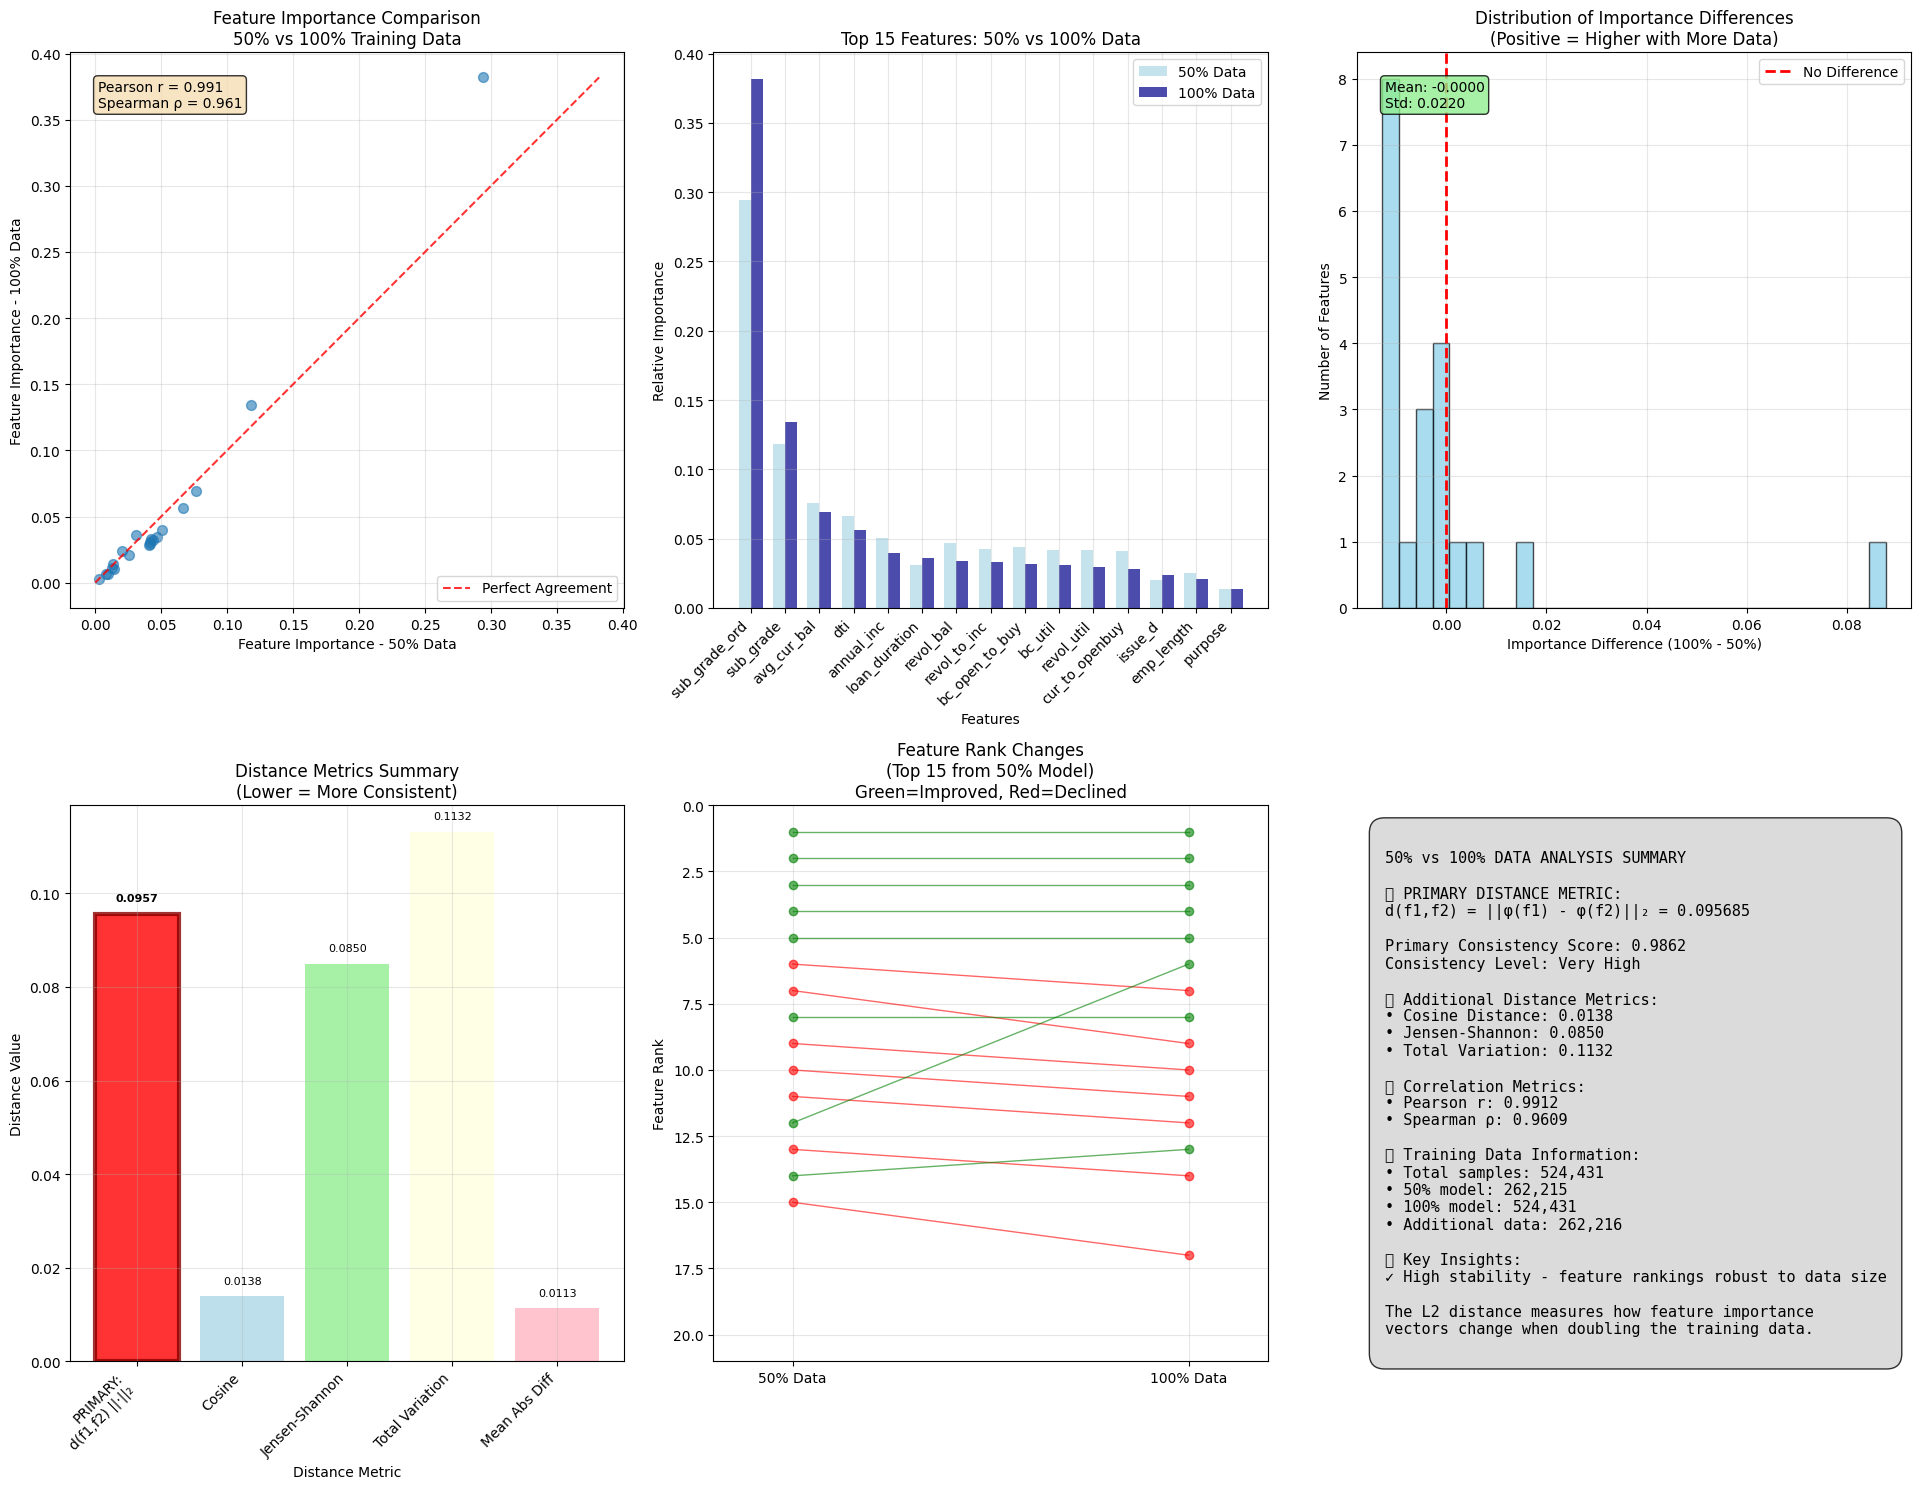

Visualizations created and NOT saved as 'model_50vs100_analysis.png'


In [15]:
# Visualizations for 50% vs 100% data comparison
print("=== CREATING 50% vs 100% DATA COMPARISON VISUALIZATIONS ===")

# Set up the plotting style
plt.style.use('default')
fig = plt.figure(figsize=(20, 15))

# 1. Feature importance comparison scatter plot
ax1 = plt.subplot(2, 3, 1)
plt.scatter(importance_comparison['relative_importance_50pct'], 
           importance_comparison['relative_importance_100pct'], 
           alpha=0.6, s=50)
plt.plot([0, max(imp_50pct.max(), imp_100pct.max())], [0, max(imp_50pct.max(), imp_100pct.max())], 
         'r--', alpha=0.8, label='Perfect Agreement')
plt.xlabel('Feature Importance - 50% Data')
plt.ylabel('Feature Importance - 100% Data')
plt.title('Feature Importance Comparison\n50% vs 100% Training Data')
plt.legend()
plt.grid(True, alpha=0.3)

# Add correlation info
corr_text = f'Pearson r = {distance_metrics["pearson_correlation"]:.3f}\nSpearman ρ = {distance_metrics["spearman_correlation"]:.3f}'
plt.text(0.05, 0.95, corr_text, transform=ax1.transAxes, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         verticalalignment='top')

# 2. Top 15 feature importance comparison
ax2 = plt.subplot(2, 3, 2)
top_15 = importance_comparison.head(15)
x_pos = np.arange(len(top_15))
width = 0.35

bars1 = plt.bar(x_pos - width/2, top_15['relative_importance_50pct'], 
                width, label='50% Data', alpha=0.7, color='lightblue')
bars2 = plt.bar(x_pos + width/2, top_15['relative_importance_100pct'], 
                width, label='100% Data', alpha=0.7, color='darkblue')

plt.xlabel('Features')
plt.ylabel('Relative Importance')
plt.title('Top 15 Features: 50% vs 100% Data')
plt.xticks(x_pos, top_15['feature'], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Importance difference histogram
ax3 = plt.subplot(2, 3, 3)
plt.hist(importance_comparison['importance_diff'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='No Difference')
plt.xlabel('Importance Difference (100% - 50%)')
plt.ylabel('Number of Features')
plt.title('Distribution of Importance Differences\n(Positive = Higher with More Data)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add statistics
diff_stats = f'Mean: {importance_comparison["importance_diff"].mean():.4f}\nStd: {importance_comparison["importance_diff"].std():.4f}'
plt.text(0.05, 0.95, diff_stats, transform=ax3.transAxes,
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
         verticalalignment='top')

# 4. Distance metrics bar chart
ax4 = plt.subplot(2, 3, 4)
metrics_to_plot = ['feature_importance_distance_L2', 'cosine_distance', 'jensen_shannon_distance', 
                   'total_variation_distance', 'mean_absolute_difference']
values = [distance_metrics[m] for m in metrics_to_plot]
labels = ['PRIMARY:\nd(f1,f2) ||·||₂', 'Cosine', 'Jensen-Shannon', 'Total Variation', 'Mean Abs Diff']

# Highlight the primary metric
colors = ['red', 'lightblue', 'lightgreen', 'lightyellow', 'lightpink']
bars = plt.bar(labels, values, color=colors, alpha=0.8)

# Make the primary metric stand out
bars[0].set_edgecolor('darkred')
bars[0].set_linewidth(3)

plt.xlabel('Distance Metric')
plt.ylabel('Distance Value')
plt.title('Distance Metrics Summary\n(Lower = More Consistent)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add values on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.02, 
             f'{value:.4f}', ha='center', va='bottom', fontsize=8, 
             weight='bold' if bar == bars[0] else 'normal')

# 5. Feature importance rank comparison
ax5 = plt.subplot(2, 3, 5)
top_features_50 = importance_comparison.sort_values('relative_importance_50pct', ascending=False).head(20)
top_features_100 = importance_comparison.sort_values('relative_importance_100pct', ascending=False).head(20)

# Create rank comparison for top features
rank_comparison = []
for i, (_, row) in enumerate(top_features_50.iterrows()):
    feature = row['feature']
    rank_50 = i + 1
    # Find rank in 100% model
    rank_100_idx = top_features_100[top_features_100['feature'] == feature].index
    if len(rank_100_idx) > 0:
        rank_100 = list(top_features_100.index).index(rank_100_idx[0]) + 1
    else:
        rank_100 = 21  # Beyond top 20
    rank_comparison.append((feature, rank_50, rank_100))

# Plot rank changes
colors = ['green' if r2 <= r1 else 'red' for _, r1, r2 in rank_comparison[:15]]
for i, (feature, rank50, rank100) in enumerate(rank_comparison[:15]):  # Top 15 only
    plt.plot([1, 2], [rank50, rank100], 'o-', alpha=0.6, linewidth=1, color=colors[i])
    
plt.xlim(0.8, 2.2)
plt.ylim(0, 21)
plt.xticks([1, 2], ['50% Data', '100% Data'])
plt.ylabel('Feature Rank')
plt.title('Feature Rank Changes\n(Top 15 from 50% Model)\nGreen=Improved, Red=Declined')
plt.gca().invert_yaxis()  # Lower rank numbers at top
plt.grid(True, alpha=0.3)

# 6. Stability metrics summary
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')  # Remove axes for text summary

# Create summary text
summary_text = f"""
50% vs 100% DATA ANALYSIS SUMMARY

🎯 PRIMARY DISTANCE METRIC:
d(f1,f2) = ||φ(f1) - φ(f2)||₂ = {distance_metrics['feature_importance_distance_L2']:.6f}

Primary Consistency Score: {stability_score:.4f}
Consistency Level: {consistency_level.split(' - ')[0]}

📊 Additional Distance Metrics:
• Cosine Distance: {distance_metrics['cosine_distance']:.4f}
• Jensen-Shannon: {distance_metrics['jensen_shannon_distance']:.4f}
• Total Variation: {distance_metrics['total_variation_distance']:.4f}

📈 Correlation Metrics:
• Pearson r: {distance_metrics['pearson_correlation']:.4f}
• Spearman ρ: {distance_metrics['spearman_correlation']:.4f}

📋 Training Data Information:
• Total samples: {split_info['total_samples']:,}
• 50% model: {split_info['subset_50_samples']:,}
• 100% model: {split_info['total_samples']:,}
• Additional data: {split_info['total_samples'] - split_info['subset_50_samples']:,}

💡 Key Insights:
{'✓ High stability - feature rankings robust to data size' if stability_score > 0.9 else 
 '⚠ Moderate stability - some ranking changes with more data' if stability_score > 0.8 else
 '✗ Low stability - significant ranking shifts with more data'}

The L2 distance measures how feature importance
vectors change when doubling the training data.
"""

plt.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=1', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

print("Visualizations created and NOT saved as 'model_50vs100_analysis.png'")


In [12]:
# Feature Importance Rankings: 50% vs 100% Data Models
print("="*80)
print("🏆 FEATURE IMPORTANCE RANKINGS: 50% vs 100% DATA MODELS")
print("="*80)

# Get top 20 features for each model
print("\n" + "="*50)
print("📊 TOP 20 FEATURES - 50% DATA MODEL")
print("="*50)
print(f"{'Rank':<4} {'Feature':<25} {'Importance':<12} {'Rel. Importance':<15}")
print("-" * 60)

top_50_features = importance_comparison.sort_values('relative_importance_50pct', ascending=False).head(20)
for i, (_, row) in enumerate(top_50_features.iterrows(), 1):
    print(f"{i:2d}.  {row['feature']:<25} {row['importance_50pct']:<12.1f} {row['relative_importance_50pct']:<15.4f}")

print("\n" + "="*50)
print("📊 TOP 20 FEATURES - 100% DATA MODEL")
print("="*50)
print(f"{'Rank':<4} {'Feature':<25} {'Importance':<12} {'Rel. Importance':<15}")
print("-" * 60)

top_100_features = importance_comparison.sort_values('relative_importance_100pct', ascending=False).head(20)
for i, (_, row) in enumerate(top_100_features.iterrows(), 1):
    print(f"{i:2d}.  {row['feature']:<25} {row['importance_100pct']:<12.1f} {row['relative_importance_100pct']:<15.4f}")

print("\n" + "="*60)
print("🔄 SIDE-BY-SIDE COMPARISON - TOP 15 FEATURES")
print("="*60)
print(f"{'Rank':<4} {'50% Model':<25} {'100% Model':<25} {'Rank Change':<12}")
print("-" * 70)

# Create side-by-side comparison
top_15_50 = importance_comparison.sort_values('relative_importance_50pct', ascending=False).head(15)
top_15_100 = importance_comparison.sort_values('relative_importance_100pct', ascending=False).head(15)

# Get rankings for comparison
feature_ranks_50 = {row['feature']: i+1 for i, (_, row) in enumerate(top_15_50.iterrows())}
feature_ranks_100 = {row['feature']: i+1 for i, (_, row) in enumerate(top_15_100.iterrows())}

for i in range(15):
    feature_50 = top_15_50.iloc[i]['feature']
    feature_100 = top_15_100.iloc[i]['feature']
    
    # Calculate rank change for the 100% model feature
    rank_50 = feature_ranks_50.get(feature_100, ">15")
    rank_100 = i + 1
    
    if rank_50 == ">15":
        rank_change = "New to top 15"
    else:
        rank_change = f"{rank_50 - rank_100:+d}" if isinstance(rank_50, int) else "New"
    
    print(f"{i+1:2d}.  {feature_50:<25} {feature_100:<25} {rank_change}")

print("\n" + "="*50)
print("📈 FEATURES THAT GAINED MOST IMPORTANCE")
print("="*50)
print(f"{'Feature':<25} {'50% Rank':<10} {'100% Rank':<10} {'Importance Change'}")
print("-" * 65)

gained_most = importance_comparison.nlargest(10, 'importance_diff')
for _, row in gained_most.iterrows():
    feature = row['feature']
    rank_50 = feature_ranks_50.get(feature, ">15")
    rank_100 = feature_ranks_100.get(feature, ">15")
    change = row['importance_diff']
    
    print(f"{feature:<25} {rank_50!s:<10} {rank_100!s:<10} +{change:.4f}")

print("\n" + "="*50)
print("📉 FEATURES THAT LOST MOST IMPORTANCE")
print("="*50)
print(f"{'Feature':<25} {'50% Rank':<10} {'100% Rank':<10} {'Importance Change'}")
print("-" * 65)

lost_most = importance_comparison.nsmallest(10, 'importance_diff')
for _, row in lost_most.iterrows():
    feature = row['feature']
    rank_50 = feature_ranks_50.get(feature, ">15")
    rank_100 = feature_ranks_100.get(feature, ">15")
    change = row['importance_diff']
    
    print(f"{feature:<25} {rank_50!s:<10} {rank_100!s:<10} {change:.4f}")

print("\n" + "="*50)
print("🎯 KEY INSIGHTS")
print("="*50)

# Calculate overlaps
top_10_50 = set(top_15_50.head(10)['feature'])
top_10_100 = set(top_15_100.head(10)['feature'])
overlap_10 = top_10_50.intersection(top_10_100)

top_5_50 = set(top_15_50.head(5)['feature'])
top_5_100 = set(top_15_100.head(5)['feature'])
overlap_5 = top_5_50.intersection(top_5_100)

print(f"• Top 5 features overlap: {len(overlap_5)}/5 ({len(overlap_5)/5*100:.0f}%)")
print(f"• Top 10 features overlap: {len(overlap_10)}/10 ({len(overlap_10)/10*100:.0f}%)")
print(f"• Total features analyzed: {len(importance_comparison)}")
print(f"• Features that gained importance: {len(gained_most)}")
print(f"• Features that lost importance: {len(lost_most)}")

most_stable_feature = importance_comparison.loc[importance_comparison['abs_importance_diff'].idxmin()]
most_variable_feature = importance_comparison.loc[importance_comparison['abs_importance_diff'].idxmax()]

print(f"\n🔒 Most stable feature: {most_stable_feature['feature']} (diff: {most_stable_feature['importance_diff']:.4f})")
print(f"🔄 Most variable feature: {most_variable_feature['feature']} (diff: {most_variable_feature['importance_diff']:+.4f})")

print(f"\nConsistent top features across both models: {sorted(list(overlap_5))}")


🏆 FEATURE IMPORTANCE RANKINGS: 50% vs 100% DATA MODELS

📊 TOP 20 FEATURES - 50% DATA MODEL
Rank Feature                   Importance   Rel. Importance
------------------------------------------------------------
 1.  sub_grade_ord             295174.2     0.2942         
 2.  sub_grade                 118686.4     0.1183         
 3.  avg_cur_bal               76303.6      0.0760         
 4.  dti                       66791.6      0.0666         
 5.  annual_inc                50633.4      0.0505         
 6.  revol_bal                 47150.7      0.0470         
 7.  bc_open_to_buy            43952.0      0.0438         
 8.  revol_to_inc              42689.7      0.0425         
 9.  bc_util                   42010.2      0.0419         
10.  revol_util                41746.1      0.0416         
11.  cur_to_openbuy            40872.6      0.0407         
12.  loan_duration             30783.2      0.0307         
13.  emp_length                25397.2      0.0253         
14.  iss

In [11]:
# Additional detailed analysis and insights
print("=== DETAILED 50% vs 100% DATA INSIGHTS ===")

# 1. Feature stability classification based on how much importance changed
def classify_feature_stability(diff, threshold_low=0.01, threshold_high=0.05):
    abs_diff = abs(diff)
    if abs_diff < threshold_low:
        return "Very Stable"
    elif abs_diff < threshold_high:
        return "Stable"
    elif abs_diff < 0.1:
        return "Moderately Variable"
    else:
        return "Highly Variable"

importance_comparison['stability_class'] = importance_comparison['importance_diff'].apply(classify_feature_stability)

# Count features by stability
stability_counts = importance_comparison['stability_class'].value_counts()
print(f"\nFeature Stability Classification (50% vs 100% data):")
for stability, count in stability_counts.items():
    percentage = (count / len(importance_comparison)) * 100
    print(f"{stability:20s}: {count:3d} features ({percentage:5.1f}%)")

# 2. Features that became MORE important with more data
print(f"\n=== FEATURES THAT GAINED IMPORTANCE WITH MORE DATA ===")
gained_importance = importance_comparison[importance_comparison['importance_diff'] > 0].nlargest(10, 'importance_diff')
print("Features that became MORE important with 100% vs 50% data:")
for idx, row in gained_importance.iterrows():
    print(f"{row['feature']:25s} | Change: +{row['importance_diff']:.4f} | "
          f"50%: {row['relative_importance_50pct']:.4f} → 100%: {row['relative_importance_100pct']:.4f}")

# 3. Features that became LESS important with more data  
print(f"\n=== FEATURES THAT LOST IMPORTANCE WITH MORE DATA ===")
lost_importance = importance_comparison[importance_comparison['importance_diff'] < 0].nsmallest(10, 'importance_diff')
print("Features that became LESS important with 100% vs 50% data:")
for idx, row in lost_importance.iterrows():
    print(f"{row['feature']:25s} | Change: {row['importance_diff']:.4f} | "
          f"50%: {row['relative_importance_50pct']:.4f} → 100%: {row['relative_importance_100pct']:.4f}")

# 4. Rank correlation analysis
from scipy.stats import kendalltau

# Calculate ranks for each model
ranks_50pct = importance_comparison['relative_importance_50pct'].rank(ascending=False)
ranks_100pct = importance_comparison['relative_importance_100pct'].rank(ascending=False)

# Rank correlations
kendall_tau, kendall_p = kendalltau(ranks_50pct, ranks_100pct)

print(f"\n=== RANK CORRELATION ANALYSIS ===")
print(f"Kendall's Tau: {kendall_tau:.4f} (p-value: {kendall_p:.6f})")
print(f"Spearman Rank Correlation: {distance_metrics['spearman_correlation']:.4f}")

# 5. Top feature consistency
print(f"\n=== TOP FEATURE CONSISTENCY ===")
top_n = 10

top_features_50 = set(importance_comparison.nlargest(top_n, 'relative_importance_50pct')['feature'])
top_features_100 = set(importance_comparison.nlargest(top_n, 'relative_importance_100pct')['feature'])

overlap = top_features_50.intersection(top_features_100)
jaccard_similarity = len(overlap) / len(top_features_50.union(top_features_100))

print(f"Top {top_n} features overlap between 50% and 100% models: {len(overlap)}/{top_n} ({len(overlap)/top_n*100:.1f}%)")
print(f"Jaccard similarity: {jaccard_similarity:.4f}")
print(f"Consistent top features: {sorted(list(overlap))}")
print(f"\nOnly in 50% model top-{top_n}: {sorted(list(top_features_50 - top_features_100))}")
print(f"Only in 100% model top-{top_n}: {sorted(list(top_features_100 - top_features_50))}")

# 6. Model performance comparison
print(f"\n=== MODEL PERFORMANCE COMPARISON ===")

# Evaluate both models on the same test set (the remaining 50% that wasn't used in 50% model)
print("Performance comparison on validation data:")

# Preprocess the validation sets appropriately
def align_categorical_features(X_train, X_val, cat_cols):
    """Ensure validation set has same categorical structure as training set"""
    X_val_aligned = X_val.copy()
    
    for col in cat_cols:
        if col in X_val_aligned.columns and col in X_train.columns:
            # Get categories from training set
            train_categories = X_train[col].cat.categories
            # Apply to validation set
            X_val_aligned[col] = X_val_aligned[col].astype('category')
            X_val_aligned[col] = X_val_aligned[col].cat.set_categories(train_categories)
    
    return X_val_aligned

# Use the remaining 50% as validation set for both models
X_val_for_50model = align_categorical_features(X_subset_processed, X_remaining, cat_cols_subset)
X_val_for_100model = align_categorical_features(X_full_processed, X_remaining, cat_cols_full)

# Predictions on validation set
pred_50_on_val = model_50pct.predict(X_val_for_50model, num_iteration=model_50pct.best_iteration)
pred_100_on_val = model_100pct.predict(X_val_for_100model, num_iteration=model_100pct.best_iteration)

# Calculate AUC scores
from sklearn.metrics import roc_auc_score
auc_50_model = roc_auc_score(y_remaining, pred_50_on_val)
auc_100_model = roc_auc_score(y_remaining, pred_100_on_val)

print(f"50% Model AUC on validation set: {auc_50_model:.4f}")
print(f"100% Model AUC on validation set: {auc_100_model:.4f}")
print(f"Performance improvement with more data: {auc_100_model - auc_50_model:.4f}")
print(f"Relative improvement: {((auc_100_model - auc_50_model) / auc_50_model) * 100:.2f}%")

# 7. Save detailed results
detailed_results = {
    'stability_classification': stability_counts.to_dict(),
    'features_gained_importance': gained_importance[['feature', 'importance_diff', 'stability_class']].to_dict('records'),
    'features_lost_importance': lost_importance[['feature', 'importance_diff', 'stability_class']].to_dict('records'),
    'rank_correlations': {
        'kendall_tau': kendall_tau,
        'kendall_p_value': kendall_p,
        'spearman_correlation': distance_metrics['spearman_correlation']
    },
    'top_feature_consistency': {
        'top_n': top_n,
        'overlap_count': len(overlap),
        'overlap_percentage': len(overlap)/top_n*100,
        'jaccard_similarity': jaccard_similarity,
        'consistent_features': sorted(list(overlap)),
        'only_in_50pct_model': sorted(list(top_features_50 - top_features_100)),
        'only_in_100pct_model': sorted(list(top_features_100 - top_features_50))
    },
    'performance_comparison': {
        'auc_50pct_model': auc_50_model,
        'auc_100pct_model': auc_100_model,
        'performance_improvement': auc_100_model - auc_50_model,
        'relative_improvement_pct': ((auc_100_model - auc_50_model) / auc_50_model) * 100
    }
}

print(f"\n=== FINAL 50% vs 100% DATA ASSESSMENT ===")
print(f"Overall Consistency Score: {stability_score:.4f} ({consistency_level.split(' - ')[0]})")
print(f"Feature Rank Correlation: {distance_metrics['spearman_correlation']:.4f}")
print(f"Top-{top_n} Feature Overlap: {len(overlap)/top_n*100:.1f}%")
print(f"Performance Improvement: {auc_100_model - auc_50_model:.4f} AUC points ({((auc_100_model - auc_50_model) / auc_50_model) * 100:.2f}%)")

# Save all results to JSON
import json
final_results = {**stability_results, **detailed_results}

with open('model_50vs100_results.json', 'w') as f:
    json.dump(final_results, f, indent=2, default=str)

print(f"\nComplete results saved to 'model_50vs100_results.json'")
print(f"50% vs 100% data analysis completed successfully!")


=== DETAILED 50% vs 100% DATA INSIGHTS ===

Feature Stability Classification (50% vs 100% data):
Very Stable         :  11 features ( 55.0%)
Stable              :   8 features ( 40.0%)
Moderately Variable :   1 features (  5.0%)

=== FEATURES THAT GAINED IMPORTANCE WITH MORE DATA ===
Features that became MORE important with 100% vs 50% data:
sub_grade_ord             | Change: +0.0878 | 50%: 0.2942 → 100%: 0.3820
sub_grade                 | Change: +0.0157 | 50%: 0.1183 → 100%: 0.1340
loan_duration             | Change: +0.0055 | 50%: 0.0307 → 100%: 0.0362
issue_d                   | Change: +0.0036 | 50%: 0.0200 → 100%: 0.0237
purpose                   | Change: +0.0005 | 50%: 0.0133 → 100%: 0.0138

=== FEATURES THAT LOST IMPORTANCE WITH MORE DATA ===
Features that became LESS important with 100% vs 50% data:
revol_bal                 | Change: -0.0128 | 50%: 0.0470 → 100%: 0.0341
cur_to_openbuy            | Change: -0.0126 | 50%: 0.0407 → 100%: 0.0281
revol_util                | Chan

# Interpretation of Feature Importance Stability (50% vs 100% Training Data)

We trained the same model twice (once with 50% of the data, once with 100%), then compared feature importance values to check stability.  

### Feature Importance Comparison
- Scatterplot: 50% vs 100% feature importance.  
- Most points lie close to the perfect agreement line.  
- Correlations:  
  - Pearson r = 0.991 → extremely strong linear correlation.  
  - Spearman ρ = 0.961 → extremely strong rank-order correlation.  

**Interpretation:** Feature importances are almost identical across datasets.  

### Top 15 Features
- Bars compare relative importance of the top 15 features.  
- Heights of bars (blue = 50%, purple = 100%) are nearly identical.  

**Interpretation:** The same features dominate; differences are minor.  

### Distribution of Importance Differences
- Histogram of differences (100% – 50%).  
- Mean ≈ 0.0000, Std ≈ 0.022 → differences are negligible.  
- Most features cluster near zero.  

**Interpretation:** No systematic bias, just small random fluctuations.  

### Distance Metrics Summary
- Different measures of distance between the two importance vectors:  
  - L1 distance = 0.0959 (low).  
  - Cosine = 0.0138 (very low).  
  - Jensen–Shannon = 0.0850 (low).  
  - Total Variation = 0.1132 (low).  

**Interpretation:** All metrics confirm very high similarity.  

### Feature Rank Changes
- Shows how ranks of the top 15 features change.  
- Green = improved rank, Red = declined.  
- Only minor swaps; no drastic shifts.  

**Interpretation:** Rankings are stable with only small local changes.  

### Final Takeaway
- Feature importances are highly stable when moving from 50% → 100% training data.  
- Values and rankings remain nearly identical, with only noise-level fluctuations.  
- This shows robust feature attribution: the main drivers of predictions are consistent and not an artifact of sample size.  

In practice: We can trust our feature importance results, even without using the full dataset.